# Run BPCA Processing

# Imports and Setup


In [2]:
from sklearn.decomposition import PCA
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import os
%pip install lime
# %pip install tensorflow==2.8.3
# %pip install tensorflow-gpu==2.8.3


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


109.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


/Users/brito/opt/anaconda3/envs/mestrado/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/Users/brito/opt/anaconda3/envs/mestrado/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
np.random.seed(77)
tf.random.set_seed(77)


In [4]:
np.set_printoptions(suppress=True)


# Load dataset

In [5]:
dataset_path = '/Volumes/SSD/datasets/food101/'


In [6]:
(train_data, test_data, valid_data), df_info = tfds.load(
    'food101',
    data_dir=dataset_path,
    # in our case we have training and validation but some dataset have testing too
    split=['train', 'validation[0%:30%]', 'validation[30%:]'],
    shuffle_files=True,  # we are shuffle our files to some randomness in our data
    as_supervised=True,  # beacuse our dataset is supervised
    with_info=True
)


In [7]:
def scale_image_data(images, labels):
    '''
    This function will scale image data to 0-1
    '''
    return images/255, labels


In [8]:
def resize_image_data(images, labels, img_size=(224, 224)):
    '''
    This function will reduce image size and change dtype int float32
    '''
    image = tf.image.resize(images, img_size)

    return tf.cast(image, dtype=tf.float32), labels


In [9]:
train_data = train_data.map(scale_image_data).map(
    resize_image_data, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(scale_image_data).map(
    resize_image_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_data.map(scale_image_data).map(
    resize_image_data, num_parallel_calls=tf.data.AUTOTUNE)


Image shape: (224, 224, 3)
Image dtype: <dtype: 'float32'>
Target class from Food101 (tensor form): 1
Target class from Food101 (str form): baby_back_ribs
Image values: 
[[[0.34805924 0.34805924 0.07354942]
  [0.3464386  0.33467388 0.07192877]
  [0.3387355  0.3182873  0.0689876 ]
  ...
  [0.7157463  0.75888354 0.7667267 ]
  [0.7116847  0.75482196 0.7626651 ]
  [0.7113641  0.75450134 0.7623445 ]]

 [[0.3787115  0.3669468  0.09635855]
  [0.36228493 0.35052022 0.08777513]
  [0.36756703 0.34711885 0.09781913]
  ...
  [0.7428574  0.78599465 0.7938378 ]
  [0.74425757 0.7873948  0.79523796]
  [0.72118807 0.77609    0.7800116 ]]]


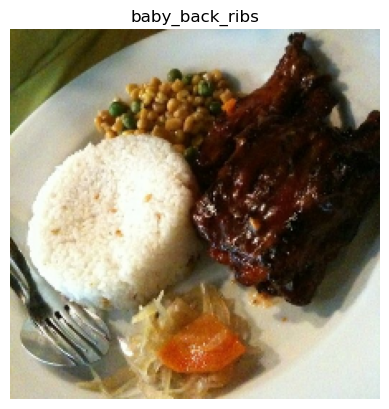

In [10]:
for image, label in train_data.take(1):
    print(f'Image shape: {image.shape}')
    print(f'Image dtype: {image.dtype}')
    print(f'Target class from Food101 (tensor form): {label}')
    print(
        f'Target class from Food101 (str form): {df_info.features["label"].int2str(label)}')
    print(f'Image values: \n{image.numpy()[:2]}')
    plt.imshow(image.numpy())
    plt.title(df_info.features["label"].int2str(label))
    plt.axis(False)


# BPCA

## BPCA using Sklearn

In [25]:
def pca_sklearn(data):
    pca = PCA(n_components=1)
    pca.fit(data)
    reduced = pca.transform(data)

    mu = np.mean(data, axis=0)
    n_comp = 1
    reversed = np.dot(
        pca.transform(data)[:, :n_comp],
        pca.components_[:n_comp, :]
    )
    reversed += mu

    return reduced, reversed


def make_blocks(input_matrix, pool_size=2, stride=2):
    height = input_matrix.shape[0]
    width = input_matrix.shape[1]
    output_matrix = []
    for i in range(0, height, stride):
        for j in range(0, width, stride):
            # fix out of bounds
            if i + pool_size > height or j + pool_size > width:
                continue
            output_matrix.append(
                input_matrix[i:i + pool_size, j:j + pool_size]
            )

    output_matrix = np.array(output_matrix)
    divisors = np.prod(output_matrix.shape[1:])
    output_matrix = output_matrix.reshape(
        int(np.prod(output_matrix.shape) / divisors),
        divisors
    )

    return output_matrix


def get_block_sides_values(block_length):
    value_1 = int(block_length ** 0.5)
    value_2 = block_length // value_1
    while value_1 * value_2 != block_length:
        value_1 += 1
        value_2 = block_length // value_1
    return value_1, value_2


def bpca_pooling_sklearn(input_matrix, pool_size=2, stride=2):
    output_matrix = make_blocks(
        input_matrix,
        pool_size=pool_size,
        stride=stride
    )
    reduced, reversed = pca_sklearn(output_matrix)
    reduced = reduced.reshape(
        int(input_matrix.shape[0] // pool_size),
        int(input_matrix.shape[1] // pool_size)
    )

    return reduced, reversed


In [26]:
input_sample_sklearn = train_data.take(1).__iter__().__next__()[0].numpy()

start = datetime.datetime.now()

# Apply BPCA with kernel size 2 and stride 2
output_step_1, reconstructed_step_1 = bpca_pooling_sklearn(
    input_sample_sklearn,
    pool_size=2,
    stride=2
)

# Apply BPCA with kernel size 2 and stride 2
output_step_2, reconstructed_step_2 = bpca_pooling_sklearn(
    output_step_1,
    pool_size=2,
    stride=2
)

# Apply BPCA with kernel size 2 and stride 2
output_step_3, reconstructed_step_3 = bpca_pooling_sklearn(
    output_step_2,
    pool_size=2,
    stride=2
)

end = datetime.datetime.now()

print(f"Time execution (seconds): {(end - start).seconds}")
print(f"Time execution (microseconds): {(end - start).microseconds}")
print("Input image shape:", input_sample_sklearn.shape)
print("Output step 1 shape:", output_step_1.shape)
print("Output step 2 shape:", output_step_2.shape)
print("Output step 3 shape:", output_step_3.shape)


Time execution (seconds): 0
Time execution (microseconds): 59434
Input image shape: (224, 224, 3)
Output step 1 shape: (112, 112)
Output step 2 shape: (56, 56)
Output step 3 shape: (28, 28)


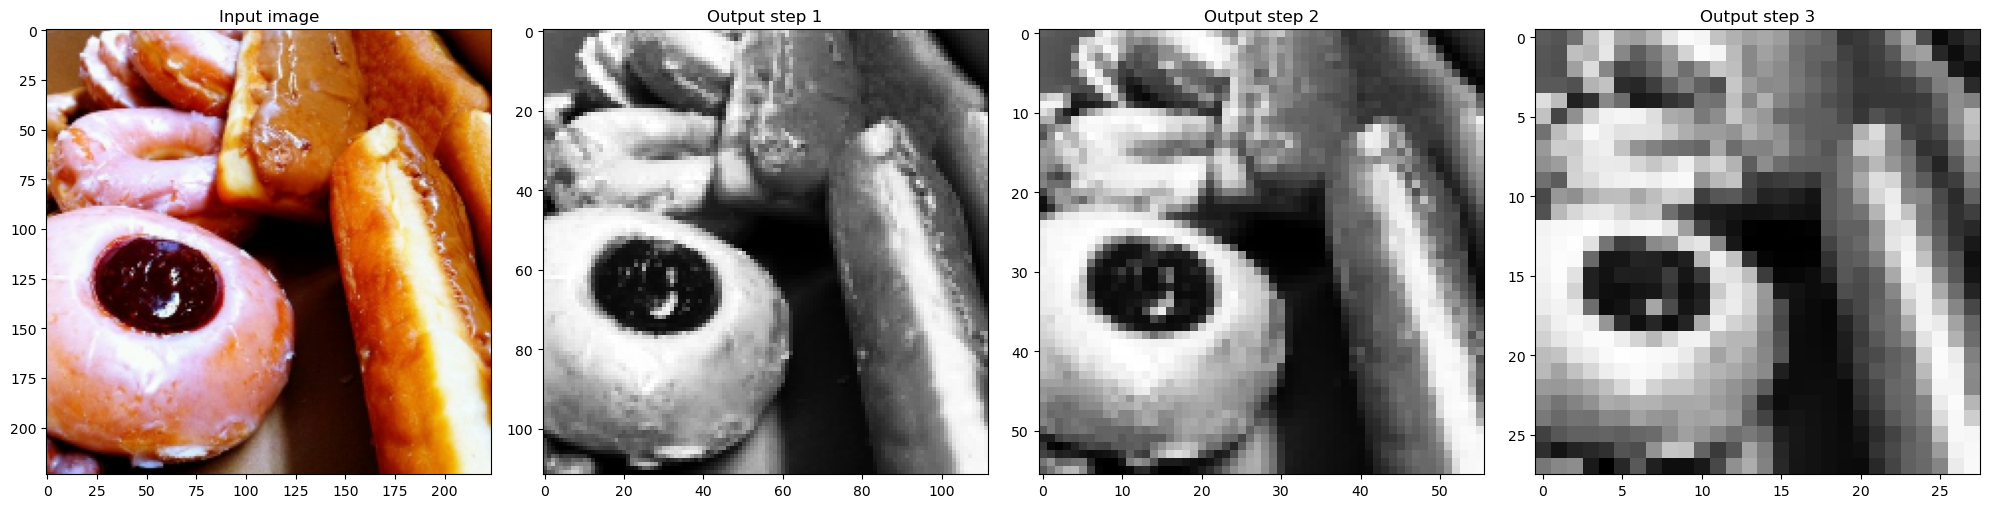

In [29]:
# Plot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))

axes[0].imshow(input_sample_sklearn, cmap="gray")
axes[0].set_title("Input image")

axes[1].imshow(output_step_1, cmap="gray")
axes[1].set_title("Output step 1")

axes[2].imshow(output_step_2, cmap="gray")
axes[2].set_title("Output step 2")

axes[3].imshow(output_step_3, cmap="gray")
axes[3].set_title("Output step 3")

plt.tight_layout()
plt.show()


## BPCA Tensorflow

In [33]:
def pca_tf(data):
    n_components = 1

    data = tf.cast(data, tf.float64)

    # Normalize the data by subtracting the mean and dividing by the standard deviation
    mean = tf.reduce_mean(data, axis=0)
    std = tf.math.reduce_std(data, axis=0)
    data = (data - mean) / std

    # Perform the Singular Value Decomposition (SVD) on the data
    s, u, v = tf.linalg.svd(data)

    # Extract the first n principal components from the matrix v
    pca_components = v[:, :n_components]

    # Perform the PCA transformation on the data
    transformed_data = tf.matmul(data, pca_components)

    # Revert the PCA transformation on the transformed data
    original_data = tf.matmul(
        transformed_data,
        tf.linalg.matrix_transpose(pca_components)
    )

    # Reconstruct the original data by multiplying by the standard deviation and adding the mean of the original data
    original_data = (
        original_data * tf.math.reduce_std(
            data,
            axis=0
        )
    ) + tf.reduce_mean(data, axis=0)

    return transformed_data, original_data


def make_blocks(input_matrix, pool_size=2, stride=2):
    n = input_matrix.shape[0]
    m = input_matrix.shape[1]
    output_matrix = []
    for i in range(0, n, stride):
        for j in range(0, m, stride):
            # fix out of bounds
            if i + pool_size > n or j + pool_size > m:
                continue
            output_matrix.append(
                input_matrix[
                    i:i + pool_size,
                    j:j + pool_size
                ]
            )

    output_matrix = np.array(output_matrix)
    divisors = np.prod(output_matrix.shape[1:])
    output_matrix = output_matrix.reshape(
        int(np.prod(output_matrix.shape) / divisors),
        divisors
    )

    return output_matrix


def bpca_pooling_tf(input_matrix, pool_size=2, stride=2):
    output_matrix = make_blocks(
        input_matrix, pool_size=pool_size, stride=stride)
    reduced, reversed = pca_tf(output_matrix)
    reduced = tf.reshape(
        reduced,
        (
            input_matrix.shape[0] // pool_size,
            input_matrix.shape[1] // pool_size
        )
    )

    return reduced, reversed


Time execution (seconds): 6
Time execution (microseconds): 614986
Input image shape: (224, 224, 3)
Output step 1 shape: (112, 112)
Output step 2 shape: (56, 56)
Output step 3 shape: (28, 28)


In [34]:
# Sample input image with shape (28, 28, 1)
input_sample_tf = input_sample_sklearn

start = datetime.datetime.now()

# Convert the image to Tensor
input_sample_tf = tf.convert_to_tensor(input_sample_tf, dtype=tf.float64)

# Apply BPCA with kernel size 2 and stride 2
output_step_1, reconstructed_step_1 = bpca_pooling_tf(
    input_sample_tf,
    pool_size=2,
    stride=2
)

# Apply BPCA with kernel size 2 and stride 2
output_step_2, reconstructed_step_2 = bpca_pooling_tf(
    output_step_1,
    pool_size=2,
    stride=2
)

# Apply BPCA with kernel size 2 and stride 2
output_step_3, reconstructed_step_3 = bpca_pooling_tf(
    output_step_2,
    pool_size=2,
    stride=2
)

end = datetime.datetime.now()

print(f"Time execution (seconds): {(end - start).seconds}")
print(f"Time execution (microseconds): {(end - start).microseconds}")
print("Input image shape:", input_sample_tf.shape)
print("Output step 1 shape:", output_step_1.shape)
print("Output step 2 shape:", output_step_2.shape)
print("Output step 3 shape:", output_step_3.shape)

Time execution (seconds): 6
Time execution (microseconds): 593318
Input image shape: (224, 224, 3)
Output step 1 shape: (112, 112)
Output step 2 shape: (56, 56)
Output step 3 shape: (28, 28)


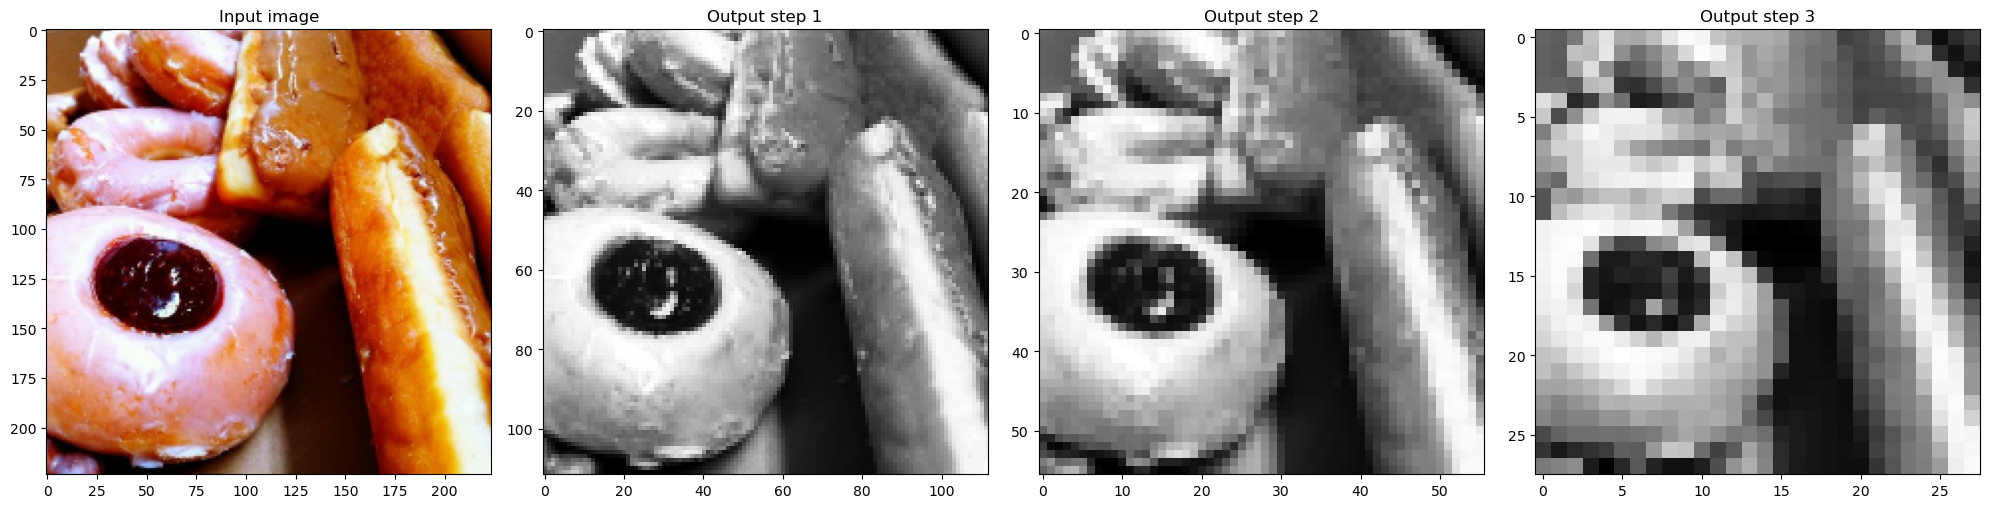

In [35]:
# Plot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))

axes[0].imshow(input_sample_tf, cmap="gray")
axes[0].set_title("Input image")

axes[1].imshow(output_step_1, cmap="gray")
axes[1].set_title("Output step 1")

axes[2].imshow(output_step_2, cmap="gray")
axes[2].set_title("Output step 2")

axes[3].imshow(output_step_3, cmap="gray")
axes[3].set_title("Output step 3")

plt.tight_layout()
plt.show()
